<span style="font-family:'Times New Roman', Times, serif; font-size:16px;">

## Question 1

## TO-DOs
- [x] Organize the data in a manageable way
- [x] Add the Spread between Corporate and 10yrs Treasury
- [x] Descriptive Statistics
- [x] Histograms and Distributions
- [x] Squared Returns 
- [ ] Correlogram
- [ ] Titles and Descriptions

In [31]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

<span style="font-family:'Times New Roman', Times, serif; font-size:16px;">

### Data Description

| Category          | Variable | 
|--------------------|-----------|
| **Equity Index**   | S&P 500 | 
| **Government Yield** | US Treasury (10-year constant maturity) |
| **Corporate Yield** | ICE BofA US Corporate Index | 
| **Commodity**       | Crude Oil WTI (CL1 Quote) |
| **Forex Rate**      | EUR/USD |


In [32]:
# data import
equity_idx = pd.read_excel('../data/SPX Index.xlsx', header=5, usecols=[4, 5], index_col=0, names=['date', 'SPX'])
commodity = pd.read_excel('../data/CL1 Comdty.xlsx', header=5, usecols=[5, 6], index_col=0, names=['date', 'Oil WTI'])
fx_rate = pd.read_excel('../data/EURUSD.xlsx', header=1, usecols=[15, 16], index_col=0, names=['date', 'EURUSD'])
gvt_yield = pd.read_excel('../data/DGS10.xlsx', sheet_name='Daily', header=0, index_col=0, names=['date', '10yr Tr. Yield'])
corporate_yield = pd.read_excel('../data/BAMLC0A0CMEY.xlsx', sheet_name='Daily, Close', header=0, index_col=0, names=['date', 'US Yields'])


<span style="font-family:'Times New Roman', Times, serif; font-size:16px;">

## Data Aggregation
In the following block of code we are going to aggregate the data into 4 DataFrames:

1. df_level : containing a raw aggregation of the data
2. df_log : containing the log-levels (for Fixed Income Sec. we performed a conversion of the Yield | compound → continuous)
3. df_log_diff : containing log-differences
4. df : comprehensive DataFrame built via an inner join of the former three.

In [33]:
# Raw Levels aggregation 
df_level = pd.concat([equity_idx, gvt_yield, corporate_yield, commodity, fx_rate], join='inner', axis=1)
df_level = df_level.dropna(axis=0)
df_level['spread 10yr_Tr-Corp'] = df_level['US Yields'] - df_level['10yr Tr. Yield']

# Log-Levels
log_eq_idx = np.log(equity_idx)
log_commodity = np.log(commodity)
log_fx = np.log(fx_rate)
log_gvt = np.log(1 + (gvt_yield / 100))
log_corp = np.log(1 + (corporate_yield / 100))

# Log Dataframe
df_log = pd.concat([log_eq_idx, log_commodity, log_fx, log_gvt, log_corp], join='inner', axis=1).dropna(axis=0)
df_log.columns = [f'log {equity_idx.columns[0]}',
                f'log {commodity.columns[0]}',
                f'log {fx_rate.columns[0]}',
                f'log {gvt_yield.columns[0]}',
                f'log {corporate_yield.columns[0]}']
df_log[f'log {df_level.columns.to_list()[-1]}'] = df_log[f'log {gvt_yield.columns[0]}'] - df_log[f'log {corporate_yield.columns[0]}']

# Log-Differences Dataframe
df_log_diff = df_log.diff().dropna(axis=0)
df_log_diff.columns = [f'logDiff {equity_idx.columns[0]}',
                f'logDiff {commodity.columns[0]}',
                f'logDiff {fx_rate.columns[0]}',
                f'logDiff {gvt_yield.columns[0]}',
                f'logDiff {corporate_yield.columns[0]}',
                f'logDiff {df_level.columns.tolist()[-1]}']
# Comprehensive Dataframe
df = pd.concat([df_level, df_log, df_log_diff], join='inner', axis=1).dropna(axis=0)

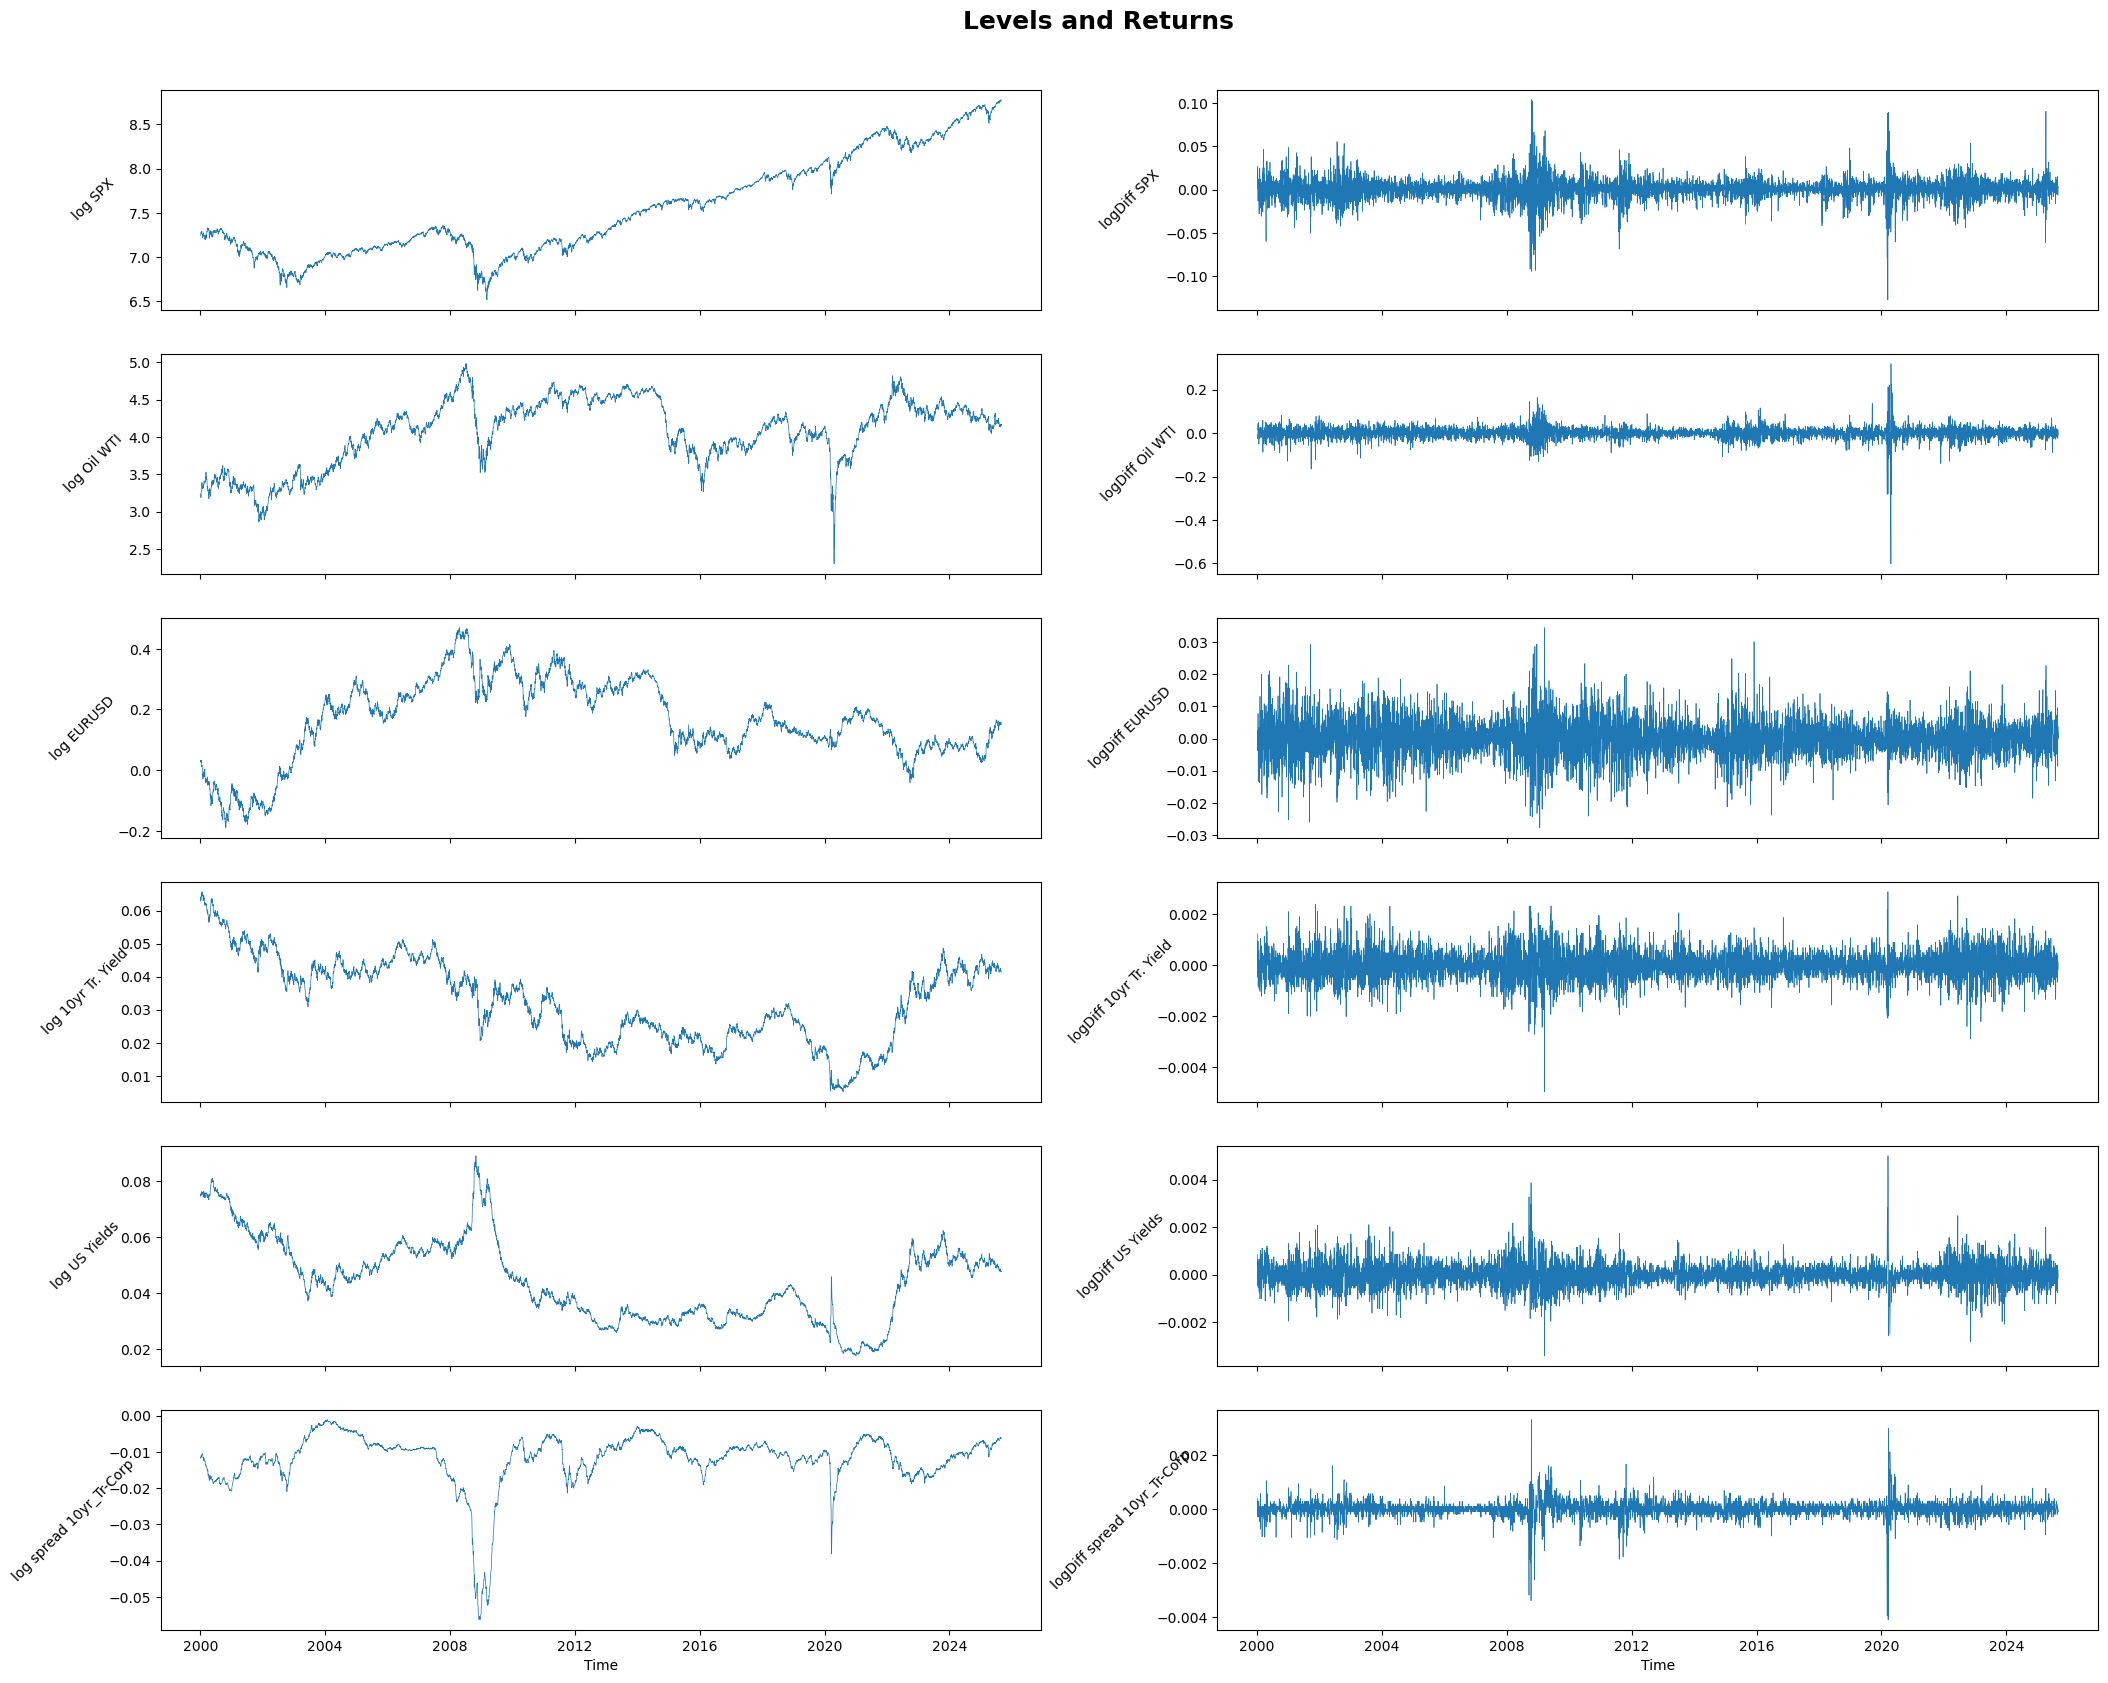

In [34]:
# Plot
names0 = df_log.columns.to_list()                                                       # Subplots names Col 0
names1 = df_log_diff.columns.to_list()                                                  # ' ' ' ' ' ' '  Col 1
nrows = 6                                               
ncols = 2
lw = .5
fig, axs = plt.subplots(nrows, ncols, sharex=True, figsize=(25, 20))                    # Plot Settings
plt.suptitle('Levels and Returns', y=0.92, fontsize=18, fontweight='bold')              # Plot Title
axs[-1, 0].set_xlabel('Time')                                                           # Plot common X-axis name
axs[-1, 1].set_xlabel('Time')                                                           # Plot common X-axis name

column = 0                                                                              # Index for plotting each column
for i in range(nrows):
    axs[i, 0].plot(df_log.index, df_log.iloc[:, column], linewidth=lw)                  # first-column subplot (Level)
    axs[i, 0].set_ylabel(f'{names0[column]}', rotation=45, labelpad=25, va='center')    # first subplot Y Label

    axs[i, 1].plot(df_log_diff.index, df_log_diff.iloc[:, column], linewidth=lw)        # second-column plot (Return)
    axs[i, 1].set_ylabel(f'{names1[column]}', rotation=45, labelpad=25, va='center')    # second subplot Y Label
    
    column += 1
plt.show()

In [35]:
# Table with the Descriptive Statistics
descriptive_stats = df_log_diff.describe().T
descriptive_stats['skew'] = df_log_diff.skew()
descriptive_stats['kurtosis'] = df_log_diff.kurt()
descriptive_stats = descriptive_stats.T
descriptive_stats

,logDiff SPX,logDiff Oil WTI,logDiff EURUSD,logDiff 10yr Tr. Yield,logDiff US Yields,logDiff spread 10yr_Tr-Corp
count,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6.390000e+03
mean,0.000239,0.000144,0.000020,-0.000003,-0.000004,8.380478e-07
std,0.012321,0.027079,0.005941,0.000565,0.000491,2.973027e-04
min,-0.127652,-0.601676,-0.027742,-0.004963,-0.003419,-4.083259e-03
25%,-0.004787,-0.012834,-0.003399,-0.000298,-0.000286,-9.971251e-05
50%,0.000637,0.001083,0.000075,0.000000,0.000000,0.000000e+00
75%,0.005954,0.013671,0.003403,0.000295,0.000284,1.009130e-04
max,0.104236,0.319634,0.034506,0.002875,0.005004,3.297235e-03
skew,-0.384888,-1.763405,0.024388,-0.017654,0.478152,-1.831787e+00
kurtosis,10.484191,51.252259,1.811047,2.383779,5.510175,3.307456e+01


In [36]:
# VarCov Matrix
varcov_matrix = df_log_diff.cov()
varcov_matrix

,logDiff SPX,logDiff Oil WTI,logDiff EURUSD,logDiff 10yr Tr. Yield,logDiff US Yields,logDiff spread 10yr_Tr-Corp
logDiff SPX,1.518107e-04,7.230997e-05,8.465609e-06,2.102358e-06,8.390309e-07,1.263327e-06
logDiff Oil WTI,7.230997e-05,7.332615e-04,1.888808e-05,2.482812e-06,8.351472e-07,1.647664e-06
logDiff EURUSD,8.465609e-06,1.888808e-05,3.528991e-05,-4.386982e-07,-5.627781e-07,1.240799e-07
logDiff 10yr Tr. Yield,2.102358e-06,2.482812e-06,-4.386982e-07,3.196337e-07,2.361071e-07,8.352661e-08
logDiff US Yields,8.390309e-07,8.351472e-07,-5.627781e-07,2.361071e-07,2.409694e-07,-4.862276e-09
logDiff spread 10yr_Tr-Corp,1.263327e-06,1.647664e-06,1.240799e-07,8.352661e-08,-4.862276e-09,8.838889e-08


In [37]:
# Correlation Matrix
corr_matrix = df_log_diff.corr()
corr_matrix

,logDiff SPX,logDiff Oil WTI,logDiff EURUSD,logDiff 10yr Tr. Yield,logDiff US Yields,logDiff spread 10yr_Tr-Corp
logDiff SPX,1.000000,0.216729,0.115660,0.301807,0.138722,0.344878
logDiff Oil WTI,0.216729,1.000000,0.117418,0.162177,0.062828,0.204664
logDiff EURUSD,0.115660,0.117418,1.000000,-0.130621,-0.192988,0.070255
logDiff 10yr Tr. Yield,0.301807,0.162177,-0.130621,1.000000,0.850750,0.496935
logDiff US Yields,0.138722,0.062828,-0.192988,0.850750,1.000000,-0.033317
logDiff spread 10yr_Tr-Corp,0.344878,0.204664,0.070255,0.496935,-0.033317,1.000000


In [38]:
from scipy.stats import norm

def pdf(df, name):
    #DataFrame to Series
    df = df.squeeze()
    
    # Moments of the Distribution
    mean = df.mean()
    st_dev = df.std()
    sk = df.skew()
    kurt = df.kurt()
    
    # Empirical Histogram
    plt.hist(df.to_numpy(), bins=100, density=True)

    # Theoretical PDF
    x = np.linspace(np.min(df), np.max(df), 100)
    pdf = norm.pdf(x, loc=mean, scale=st_dev)
    plt.plot(x, pdf)

    # Formatting a legend with main distribution specs
    text = (
        f"Mean = {mean:.2f}\n"
        f"Std.Dev. = {st_dev:.2f}\n"
        f"Skewness = {sk:.2f}\n"
        f"Kurtosis = {kurt:.2f}"
    )
    plt.legend(title=text, loc='upper right', fontsize=9, title_fontsize=10)
    
    # Labels and Title
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.title(f'Empirical vs Normal PDF ({name})')
    
    plt.grid(alpha=0.3)
    plt.show()

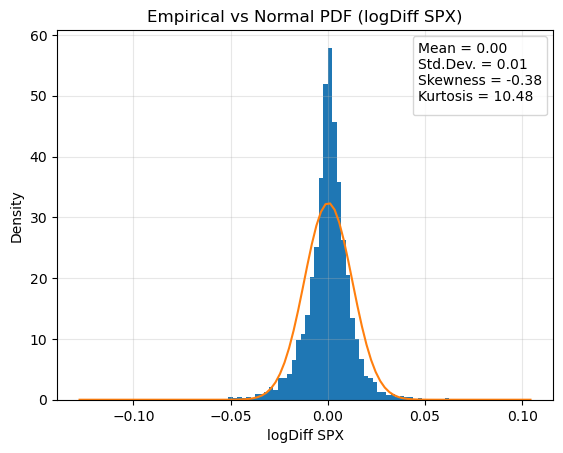

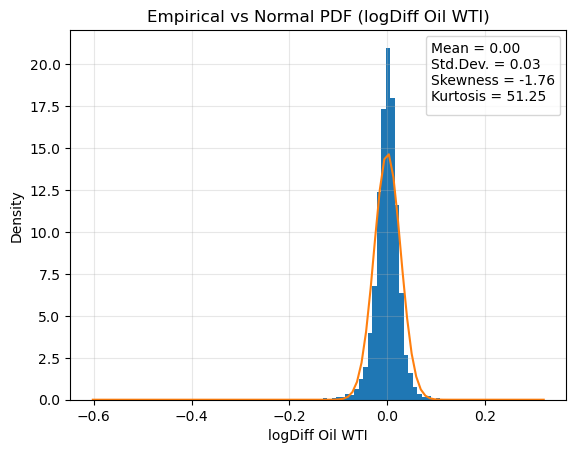

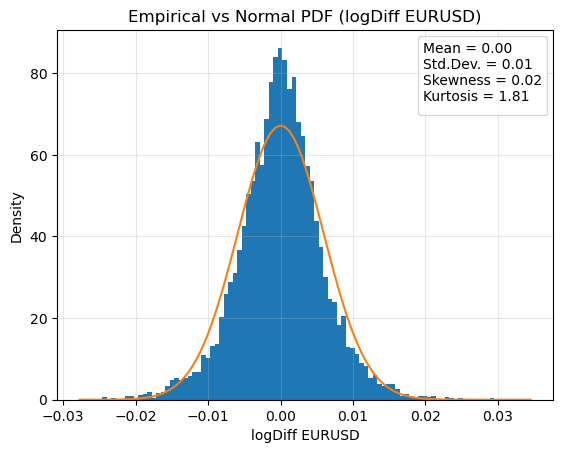

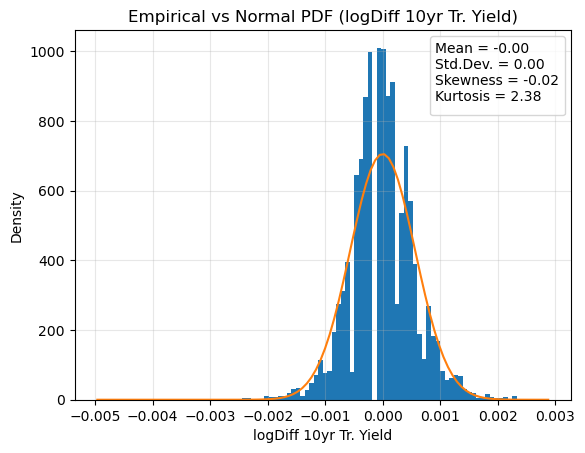

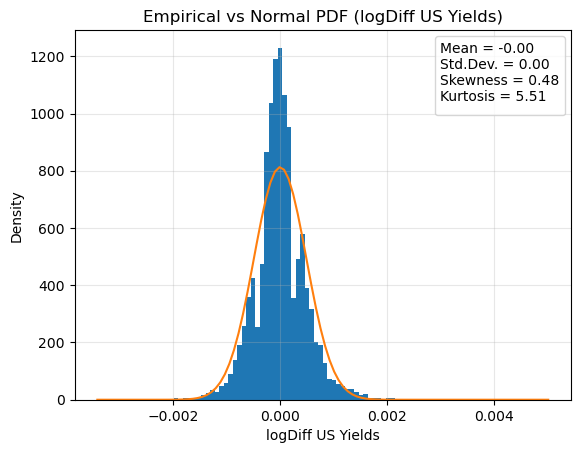

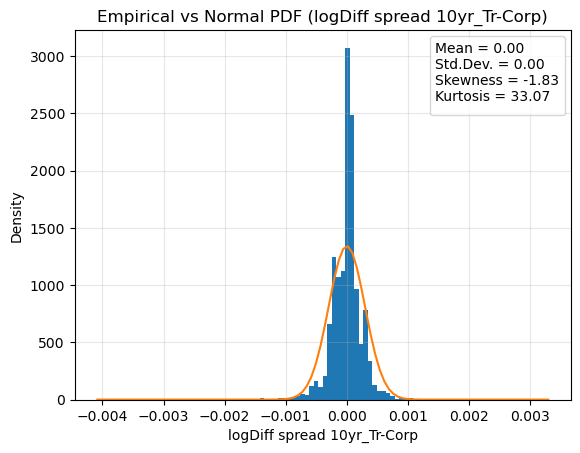

In [39]:
names = df_log_diff.columns.to_list()                                                  # ' ' ' ' ' ' '  Col 1
nrows = 6                                               

# Index for plotting each column

for i in range(nrows):
    pdf(df_log_diff.iloc[:, i], names[i])


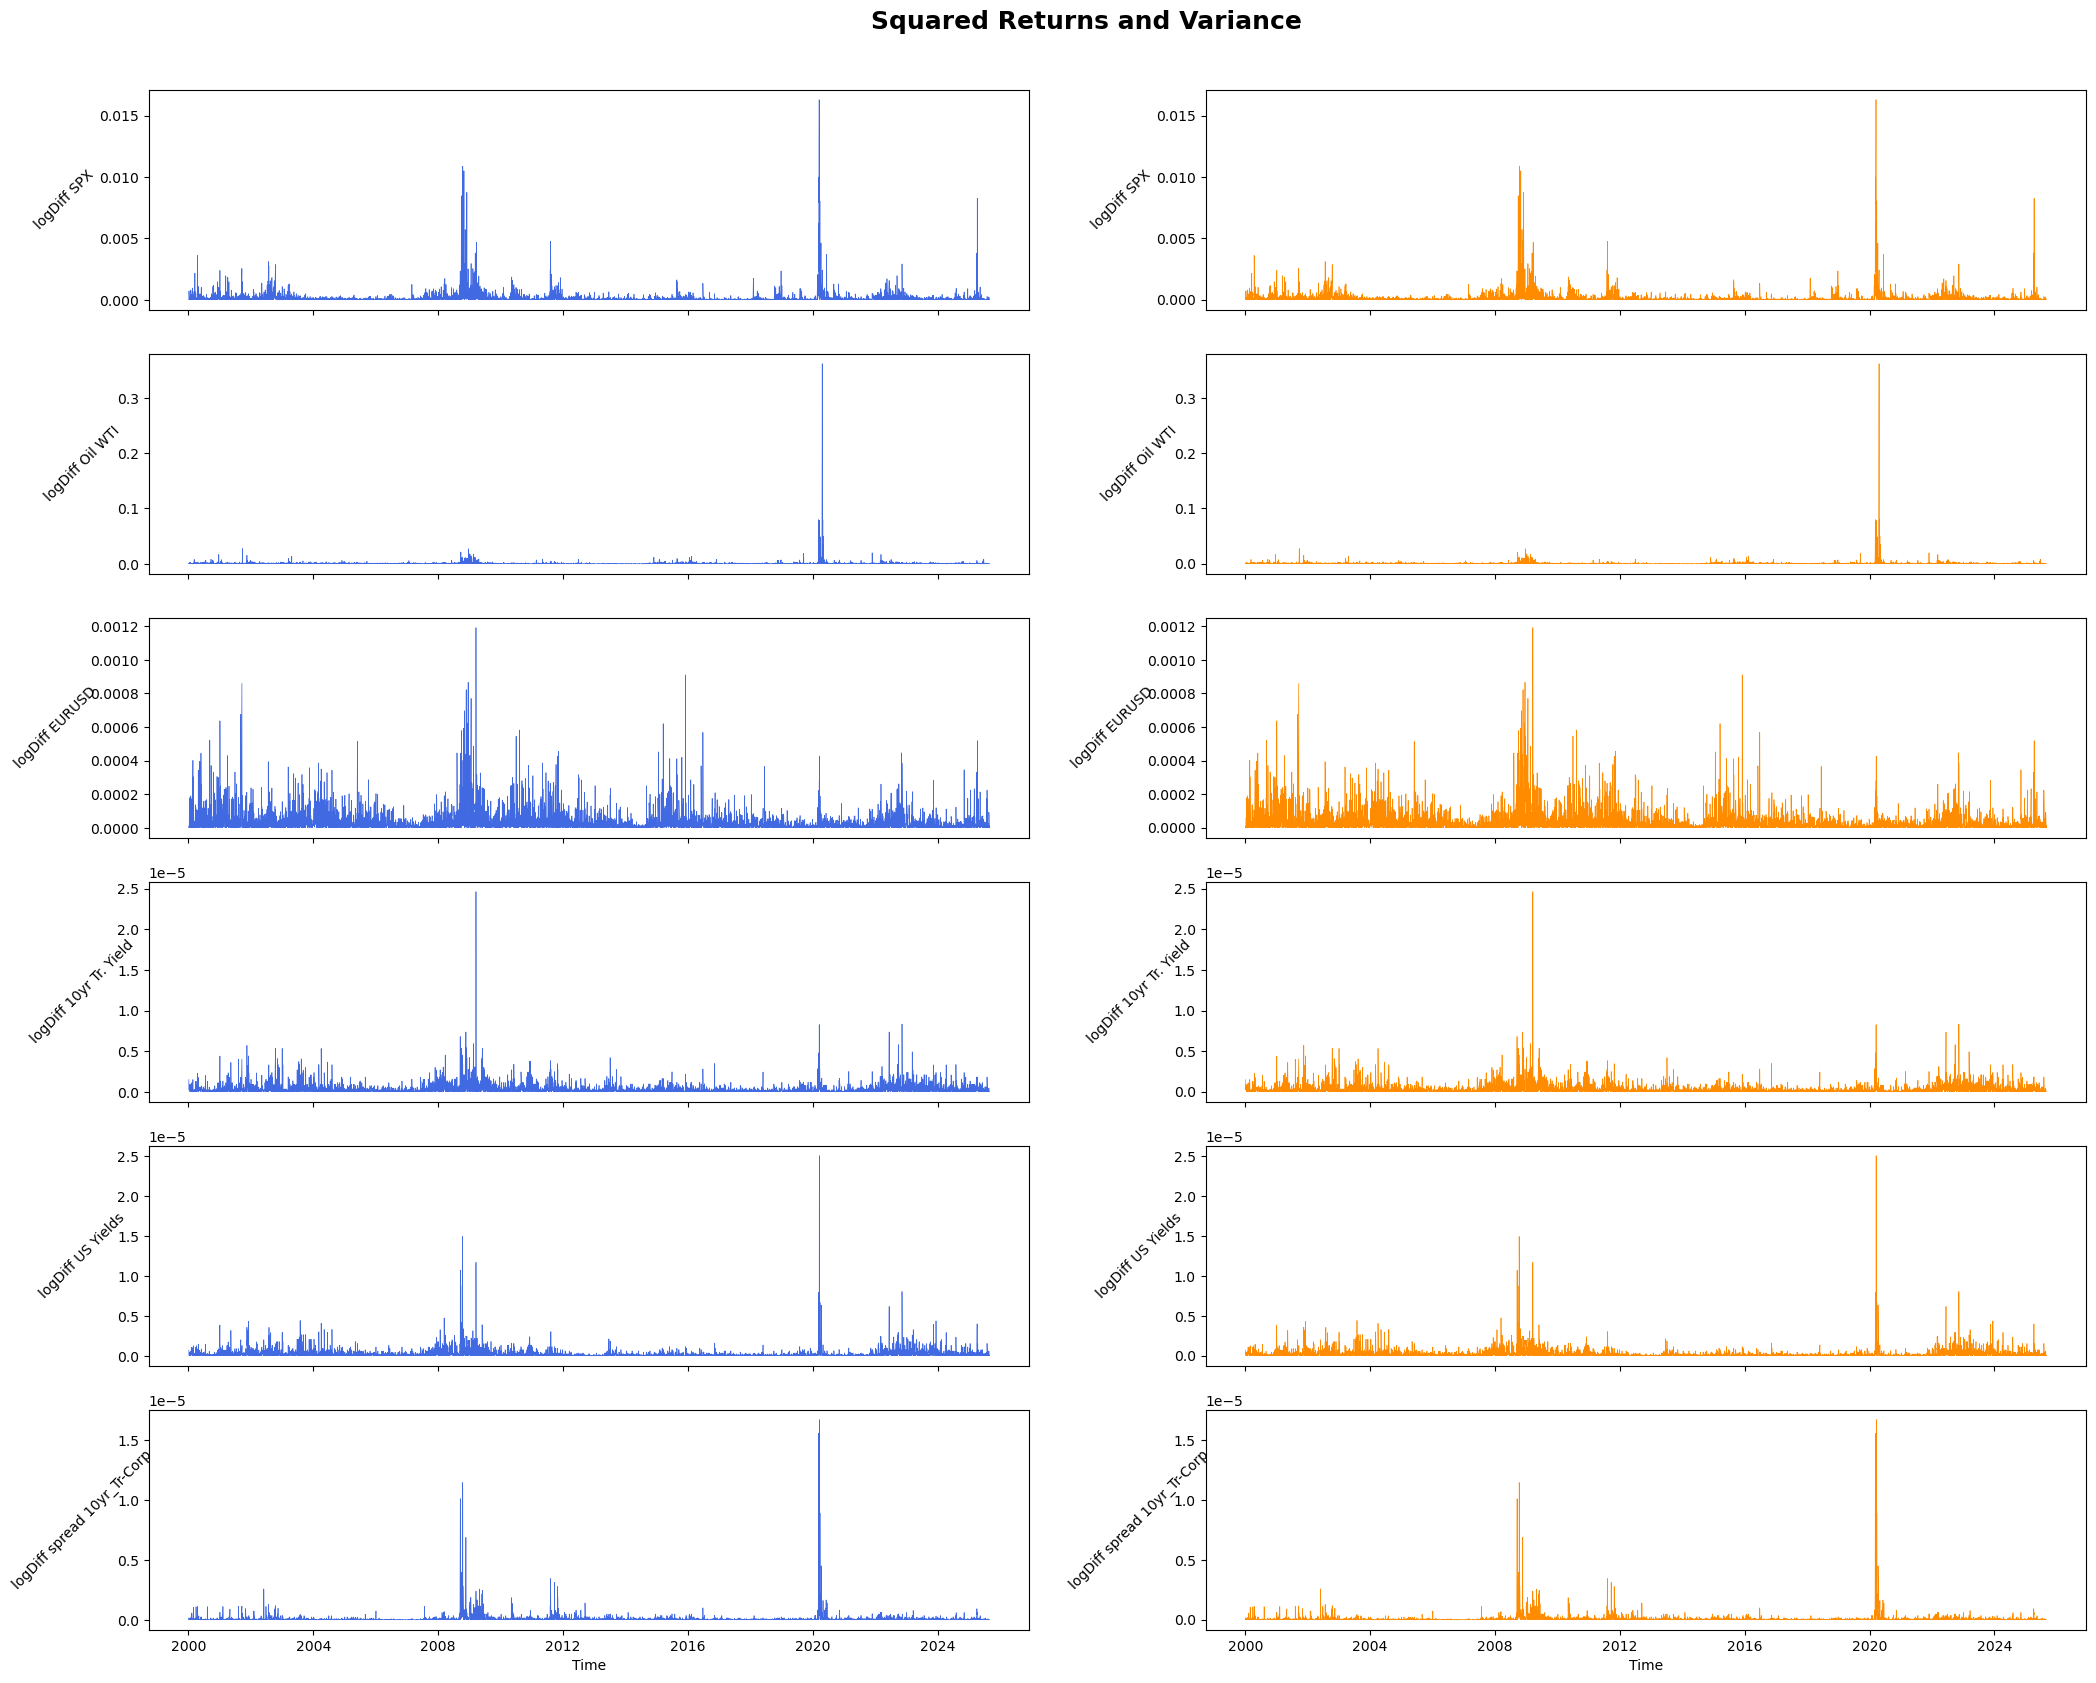

In [ ]:
# Calculation of Squared Returns and Variance
df_sq_ret = df_log_diff ** 2                      
df_mean = df_log_diff.mean(axis=0)                
df_var = df_sq_ret - (df_mean ** 2)               

# Column Names
names_sq = df_sq_ret.columns.to_list()
names_var = df_var.columns.to_list()

# Plot Settings
nrows = 6
ncols = 2
lw = 0.5
fig, axs = plt.subplots(nrows, ncols, sharex=True, figsize=(25, 20))
plt.suptitle('Squared Returns and Variance', y=0.92, fontsize=18, fontweight='bold')

axs[-1, 0].set_xlabel('Time')
axs[-1, 1].set_xlabel('Time')

# Plot
column = 0
for i in range(nrows):
    # Left Column → squared returns
    axs[i, 0].plot(df_sq_ret.index, df_sq_ret.iloc[:, column], linewidth=lw, color='royalblue')
    axs[i, 0].set_ylabel(f'{names_sq[column]}', rotation=45, labelpad=25, va='center')

    # Right Column → varianza centrata
    axs[i, 1].plot(df_var.index, df_var.iloc[:, column], linewidth=lw, color='darkorange')
    axs[i, 1].set_ylabel(f'{names_var[column]}', rotation=45, labelpad=25, va='center')

    column += 1

plt.show()

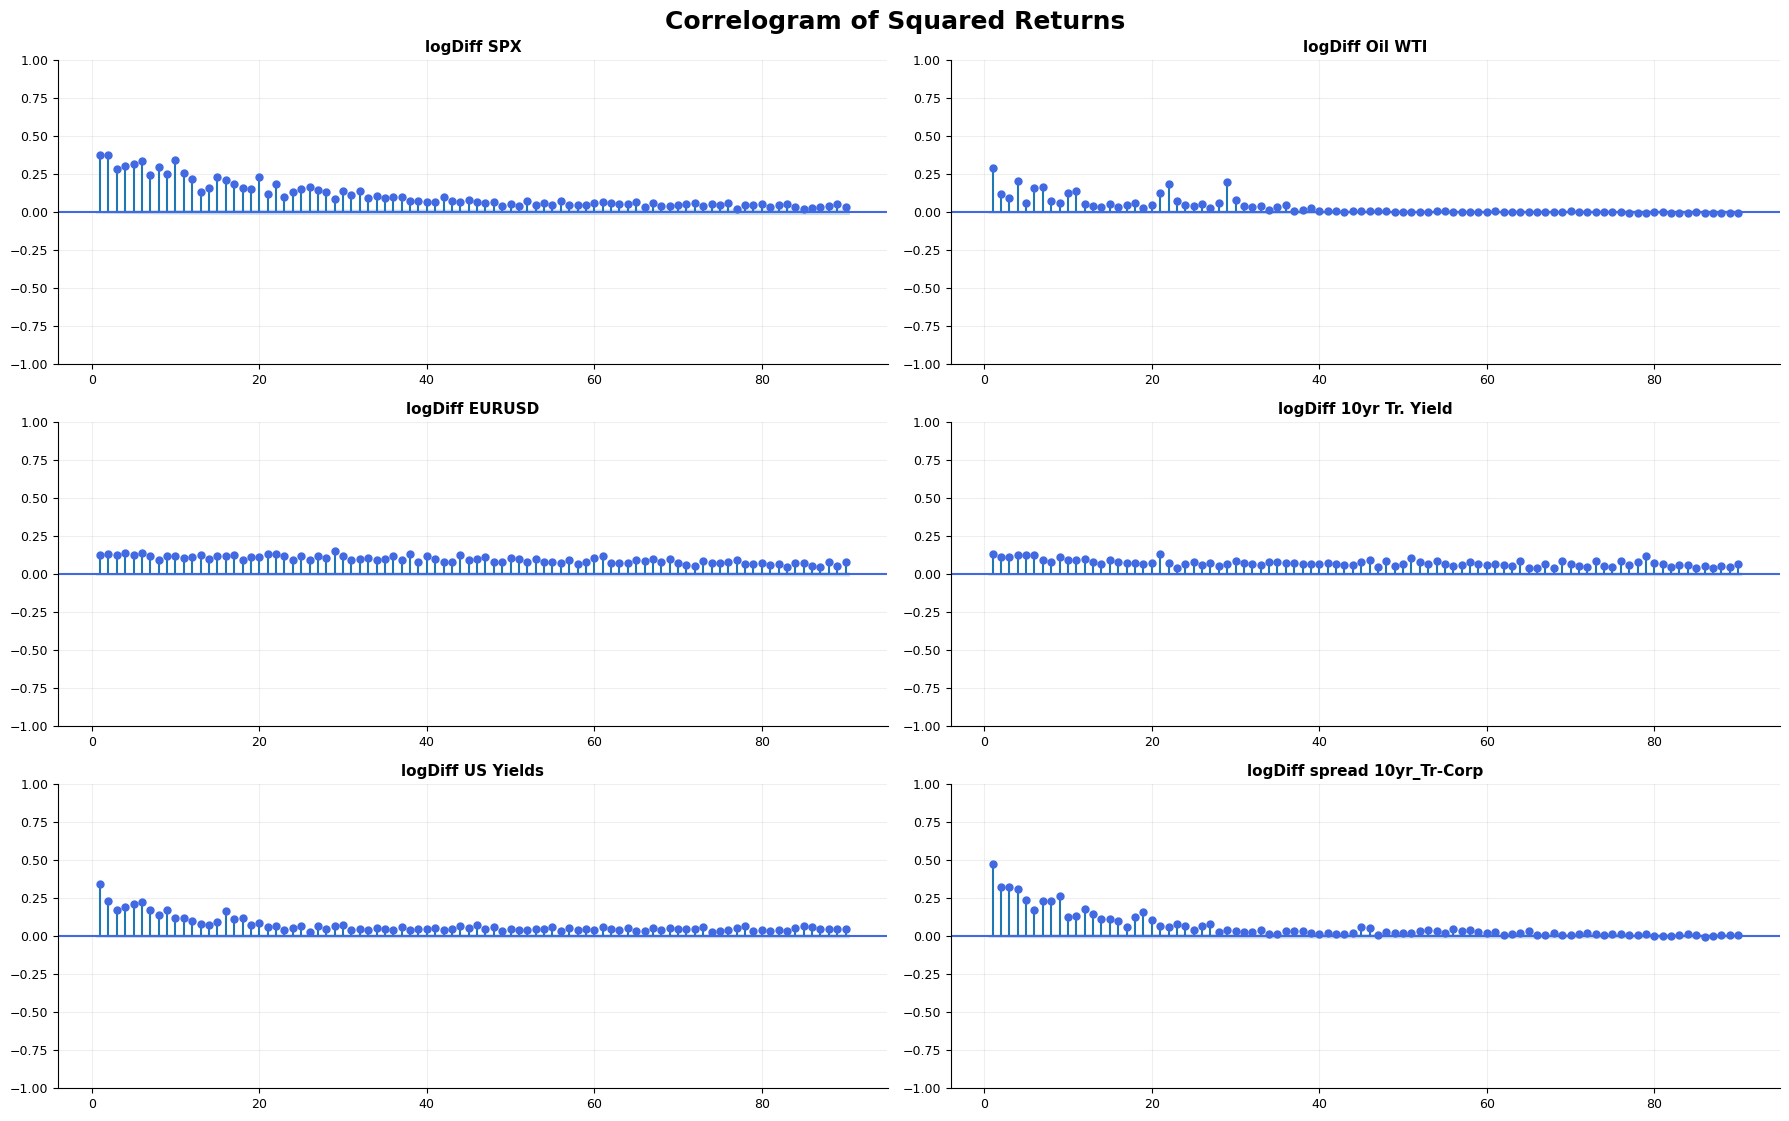

In [ ]:
# Plot Settings
nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12))
plt.suptitle('Correlogram of Squared Returns', y=0.93, fontsize=18, fontweight='bold')
